# DGD Training Demo: Using the DGDTrainer Class

This notebook demonstrates the complete usage of the DGDTrainer class from `src/training/trainer.py`. We'll train a Deep Generative Decoder (DGD) model on the FashionMNIST dataset using the standard production configuration, showcasing:

- Configuration setup using Hydra/OmegaConf with the standard config
- Dataset preparation and data loading
- ClearML integration for experiment tracking
- Model training with representation layers and GMM fitting
- Visualization of training progress and results
- Model evaluation and sample generation
- Model saving and loading

The DGD model combines:
- **Representation Layer**: Learnable per-sample embeddings in latent space
- **Convolutional Decoder**: Neural network that maps latent codes to images
- **Gaussian Mixture Model**: Probabilistic model fitted to the learned representations

**Note**: This demo uses the standard production configuration for full model capacity. If you have limited GPU memory, you can uncomment the memory optimization lines in the configuration section.

## 1. Setup Environment and Imports

First, let's import all necessary libraries and set up the environment.

In [1]:
import os
import sys
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from hydra import initialize, compose
from clearml import Task

current_dir = Path.cwd()
if 'notebooks' in current_dir.parts:
    project_root = current_dir.parent
else:
    project_root = current_dir

sys.path.append(str(project_root))
sys.path.append(str(project_root / 'src'))

from src.training.trainer import DGDTrainer
from src.data.dataloader import create_dataloaders, get_sample_batches, save_sample_batches
from src.visualization import plot_images_by_class, plot_generated_samples
from src.utils import setup_device, set_random_seed, setup_cuml_acceleration

# Setup device (automatically selects best GPU or falls back to CPU)
device = setup_device(verbose=True)

# Set random seeds for reproducibility
set_random_seed(seed=42, device=device)

# Try to enable cuML GPU acceleration
setup_cuml_acceleration(verbose=True)

Number of CUDA devices: 1
Using CUDA: NVIDIA GeForce RTX 4060 Laptop GPU (8.2 GB total memory)
cuML GPU acceleration enabled
cuML GPU acceleration enabled


## 2. Load Configuration

Load the training configuration using Hydra/OmegaConf. We'll use the standard production configuration which provides full model capacity and training settings. You can optionally apply memory optimizations if running on limited hardware.

In [2]:
config_dir = project_root / "config"
relative_config_path = "../config"

with initialize(version_base=None, config_path=relative_config_path):
    config = compose(config_name="config")

print("CONFIGURATION")
print(f"{'='*60}")
print(OmegaConf.to_yaml(config))
print(f"{'='*60}")

CONFIGURATION
random_seed: 42
experiment_name: ImageDGD_Default
description: Default ImageDGD training configuration
clearml:
  enabled: false
  project_name: ImageDGD
  task_name: Default_Training
  tags:
  - default
  - production
data:
  dataset_name: FashionMNIST
  root_dir: ./data
  batch_size: 64
  num_workers: 1
  pin_memory: true
  total_subset_fraction: 0.2
  test_split: 0.5
  normalize: true
  download: true
  shuffle_train: true
  shuffle_test: false
  transforms:
    train:
    - ToTensor
    - Normalize
    test:
    - ToTensor
    - Normalize
  class_names:
  - Ankle boot
  - Bag
  - Coat
  - Dress
  - Pullover
  - Sandal
  - Shirt
  - Sneaker
  - T-shirt/top
  - Trouser
model:
  representation:
    n_features: 8
    distribution: uniform_ball
    dist_params:
      radius: 1.0
  decoder:
    hidden_dims:
    - 32
    - 16
    output_channels: 1
    output_size:
    - 28
    - 28
    init_size:
    - 4
    - 4
    kernel_size: 3
    stride: 2
    padding: 1
    output_pad

## 3. Prepare Dataset and Data Loaders

Load and prepare the FashionMNIST dataset with proper transformations and create data loaders.

Using 20% of total data with 50/50 test/train split
Adjusted batch size: 64
Train dataset: 7000 samples (10.0% of total)
Test dataset: 7000 samples (10.0% of total)
Total original data: 70000 samples
Image shape: torch.Size([1, 28, 28])
Image size: 784
- Train loader: 110 batches
- Test loader: 110 batches
- Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Saved sample batches to /home/asp/Downloads/HeaDS/ImageDGD/data/samples/visualization_samples.pt
  Train samples: 50
  Test samples: 50
Saved sample batches to /home/asp/Downloads/HeaDS/ImageDGD/data/samples/visualization_samples.pt
  Train samples: 50
  Test samples: 50


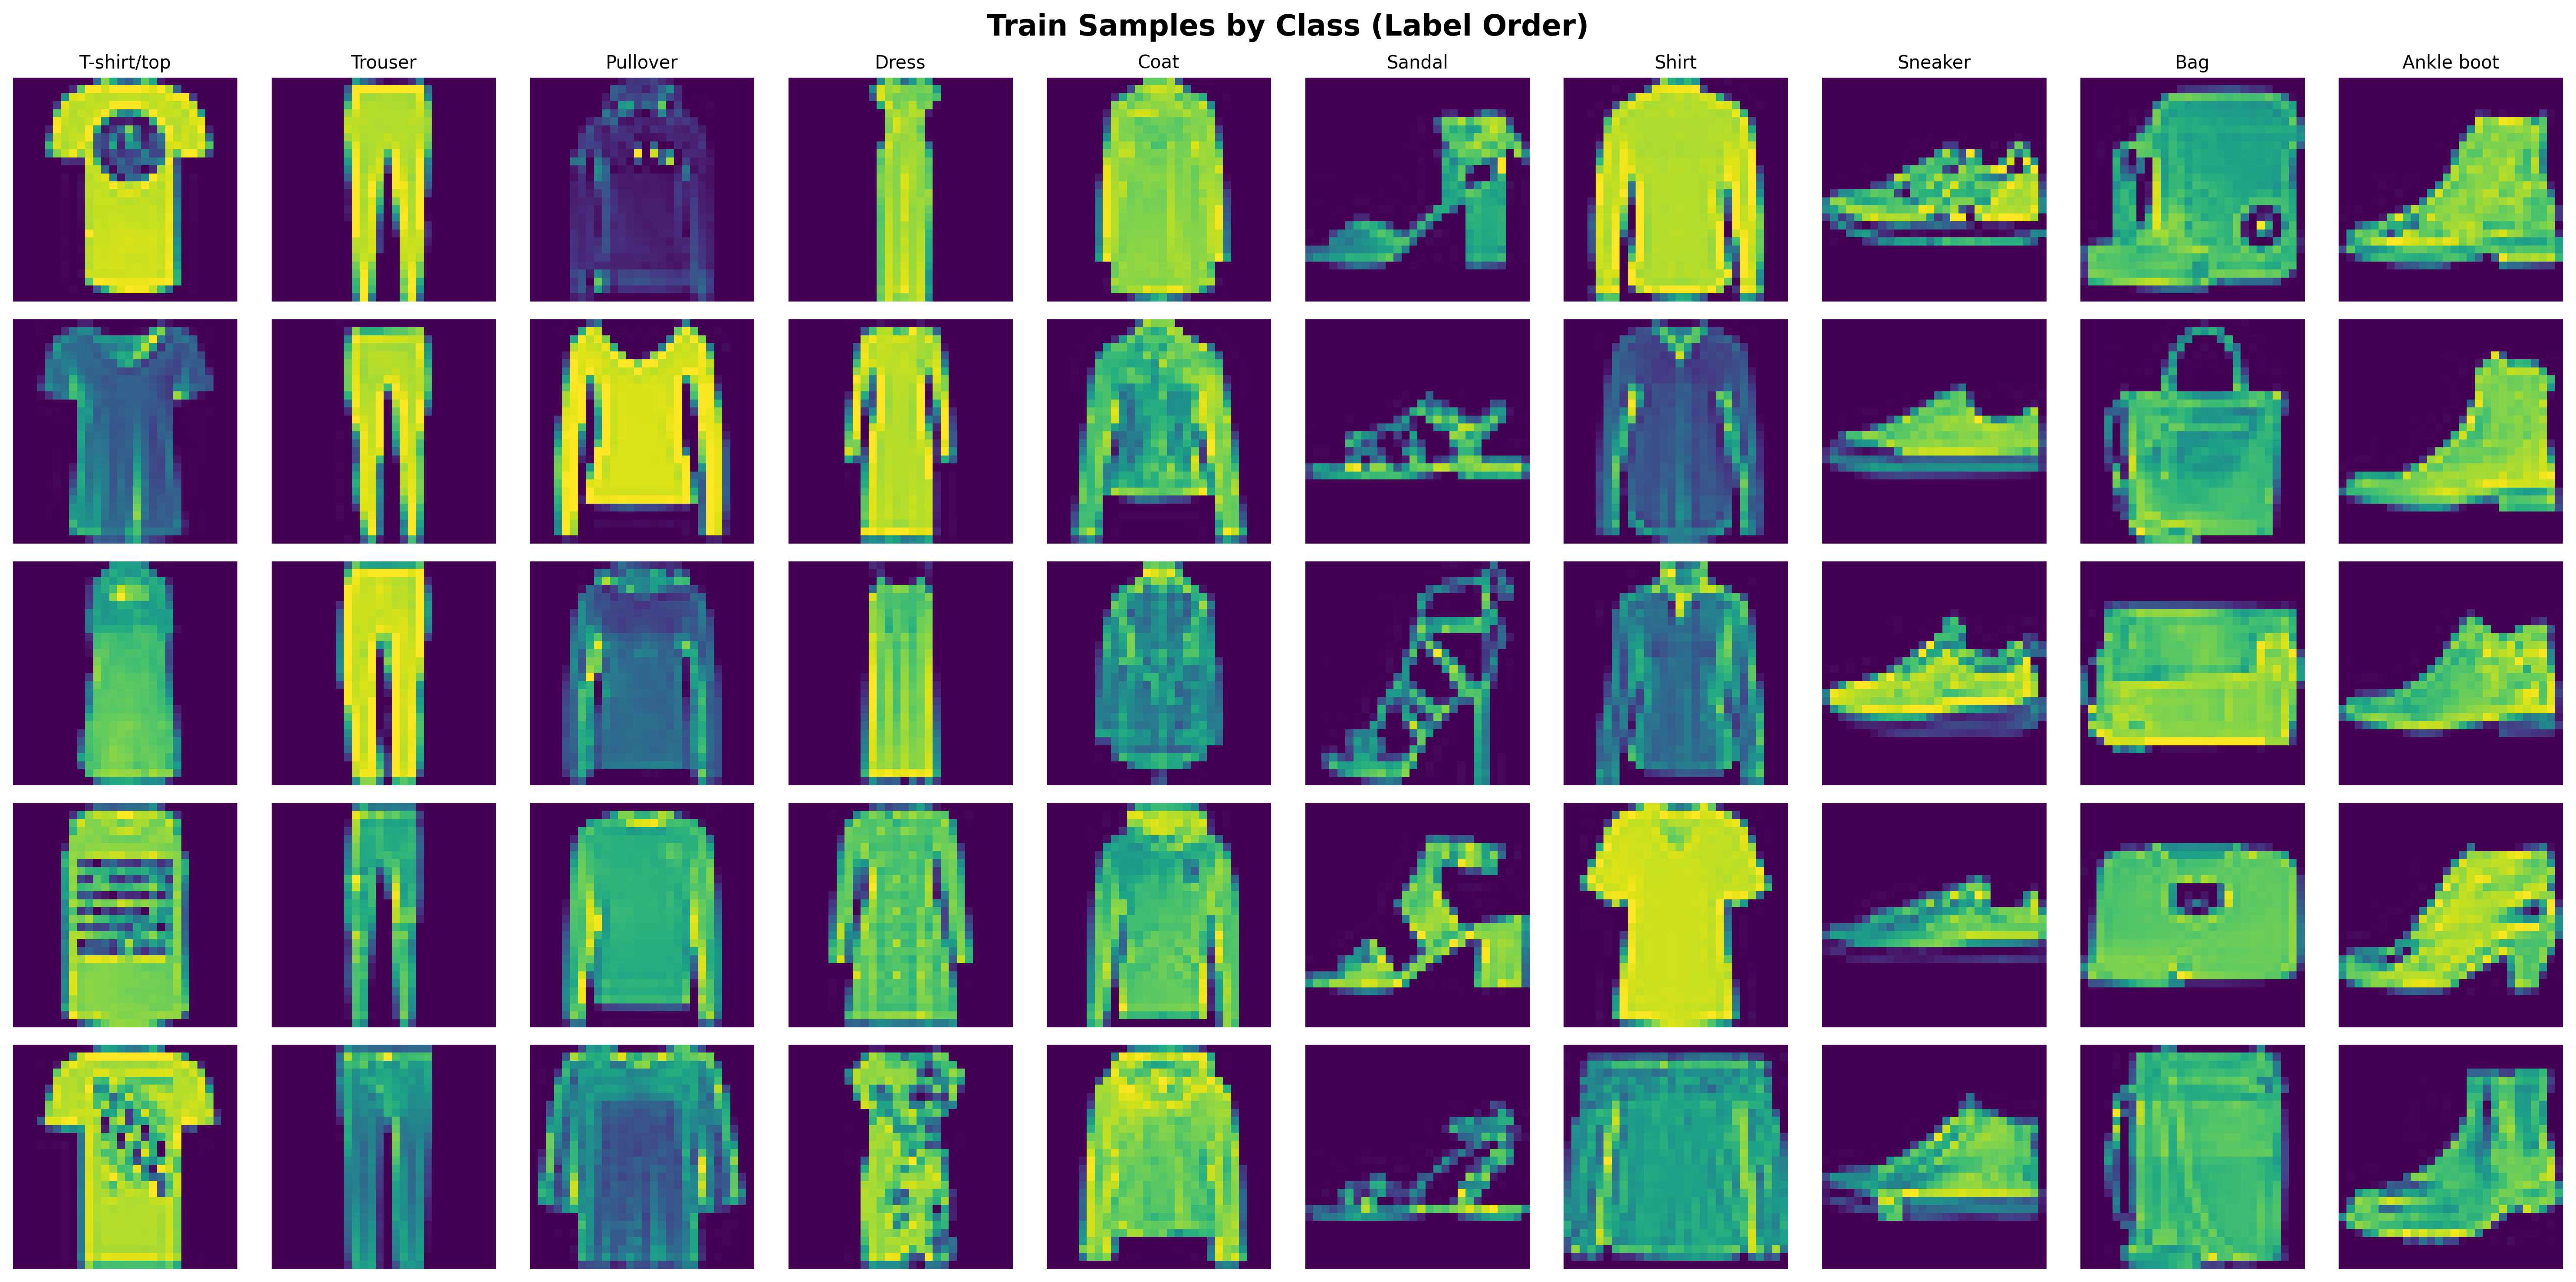

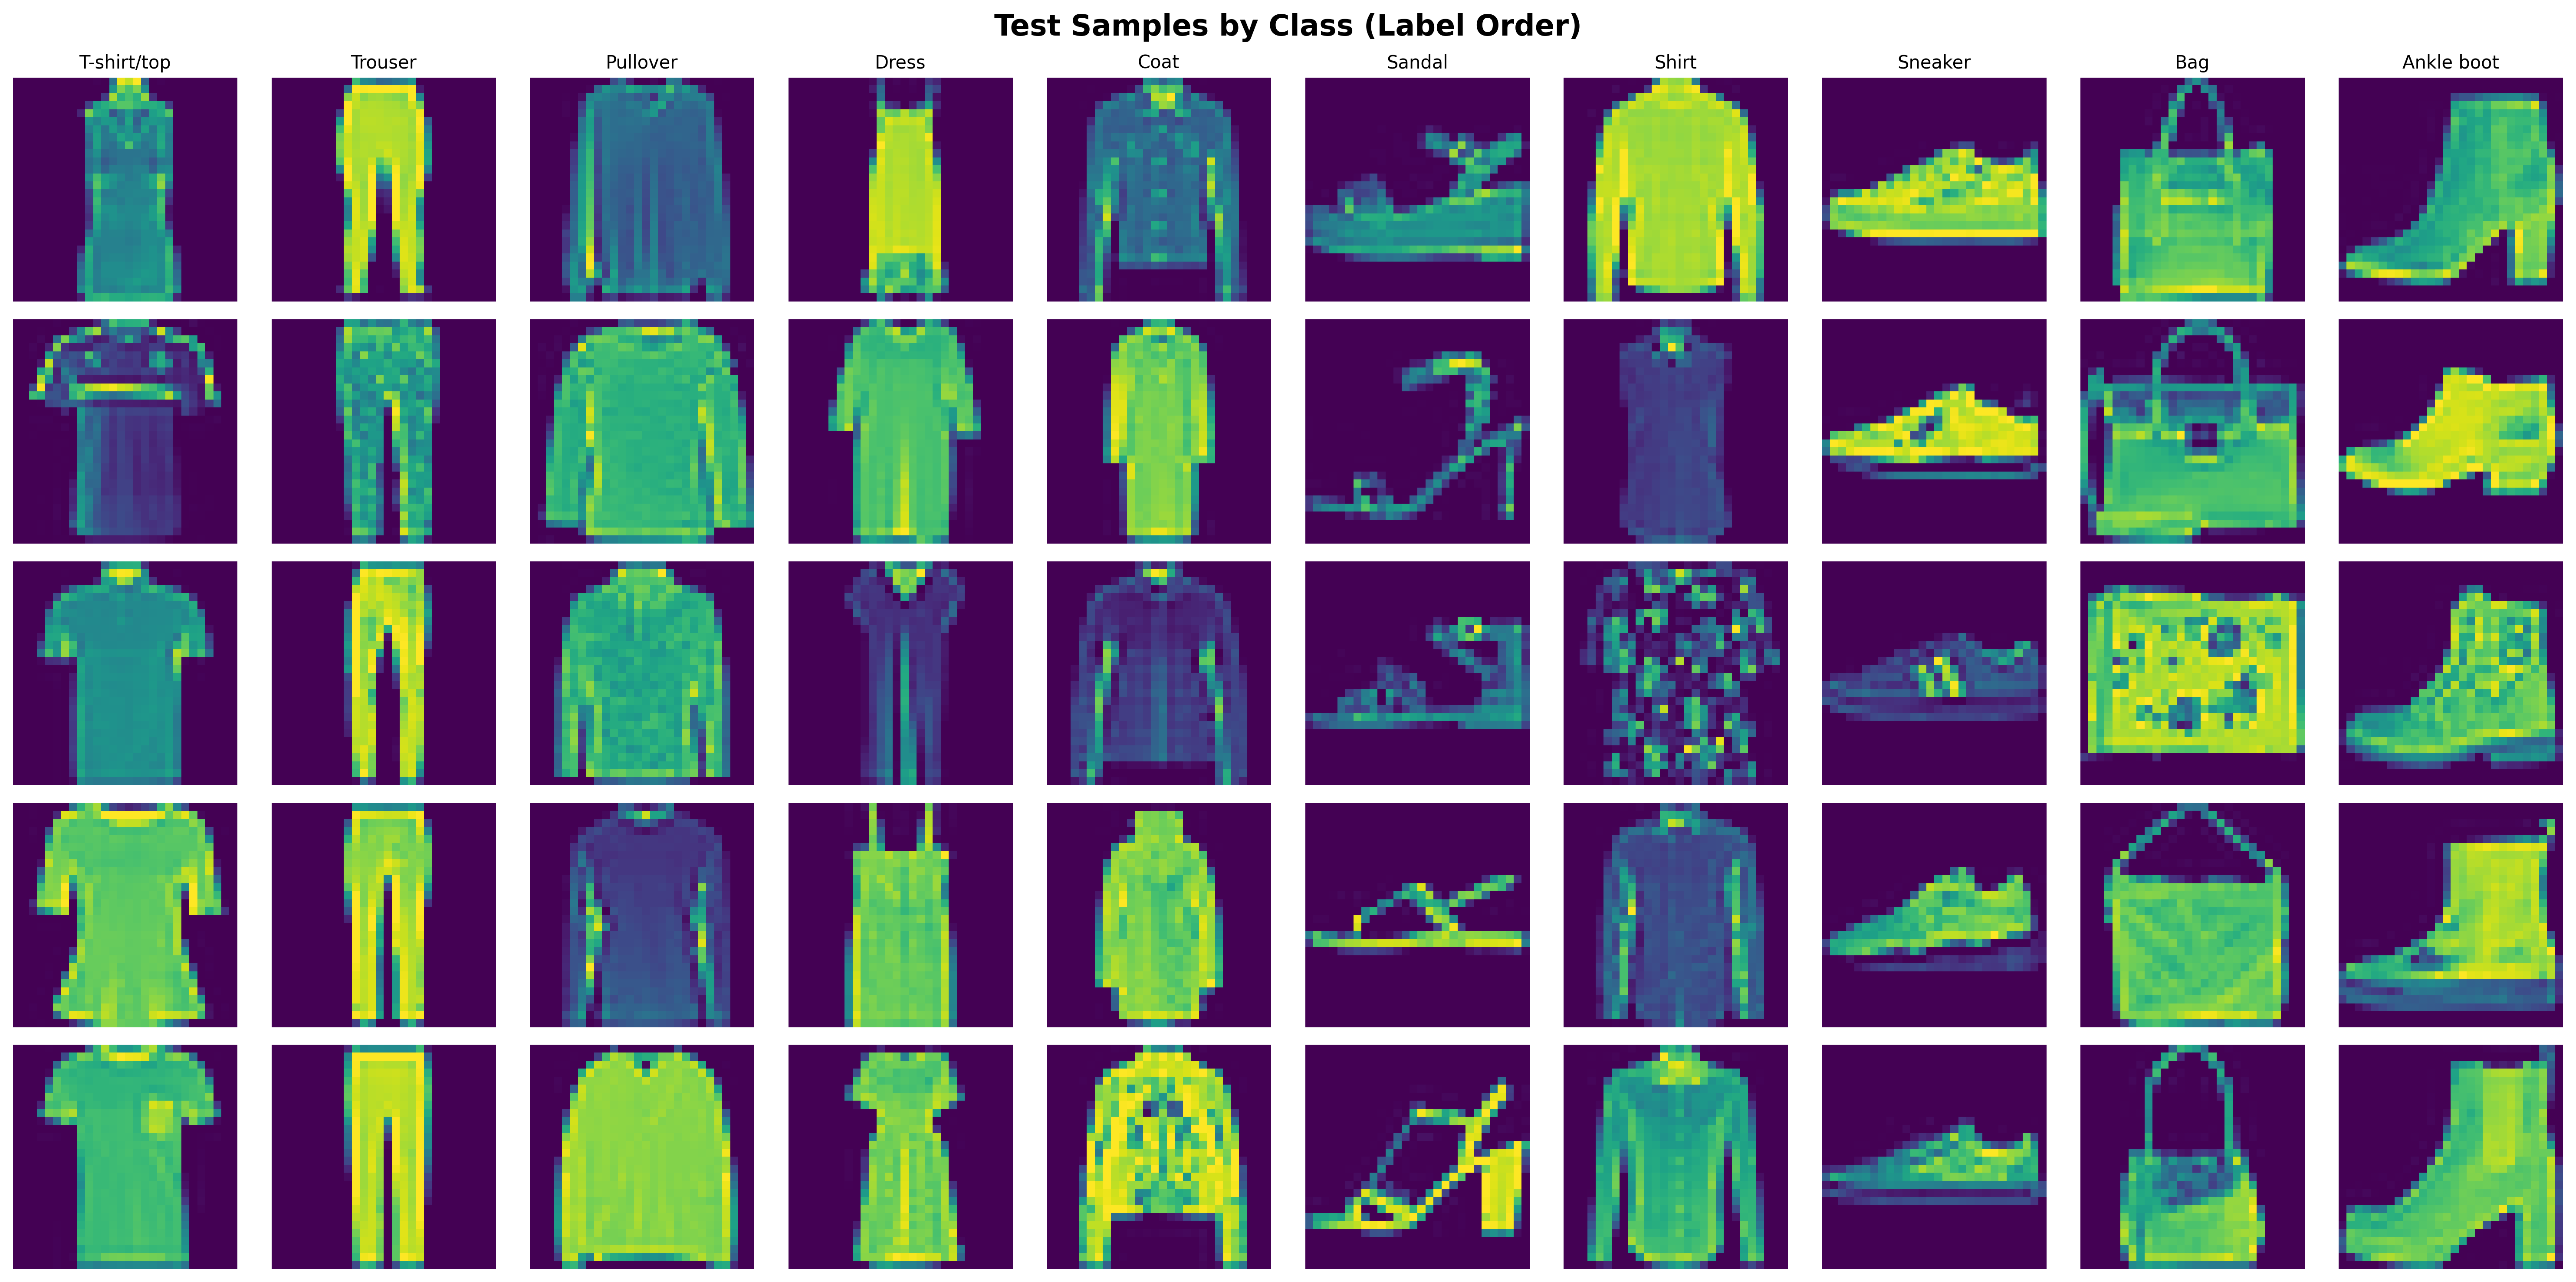

In [3]:
# Create data directories
data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

# Create data loaders
train_loader, test_loader, class_names = create_dataloaders(config)

print(f"- Train loader: {len(train_loader)} batches")
print(f"- Test loader: {len(test_loader)} batches")
print(f"- Classes: {class_names}")

# Collect samples with guaranteed class coverage
sample_data = get_sample_batches(train_loader, test_loader, device=device, n_per_class=5, n_classes=len(class_names))

# Save samples for later inference
samples_dir = project_root / "data" / "samples"
samples_dir.mkdir(exist_ok=True)
sample_save_path = samples_dir / "visualization_samples.pt"
save_sample_batches(sample_data, str(sample_save_path))

# Unpack sample data
indices_train, images_train, labels_train, indices_test, images_test, labels_test = sample_data

# Visualize train samples
plot_images_by_class(
    images=images_train,
    labels=labels_train,
    class_names=class_names,
    title='Train Samples by Class (Label Order)',
    n_per_class=5,
    cmap='viridis'
)
plt.show()

# Visualize test samples
plot_images_by_class(
    images=images_test,
    labels=labels_test,
    class_names=class_names,
    title='Test Samples by Class (Label Order)',
    n_per_class=5,
    cmap='viridis'
)
plt.show()

### Loading Saved Samples for Inference

The samples have been saved to disk and can be reloaded later for inference or evaluation. This is useful for:
- Consistent evaluation across different model versions
- Reproducible visualizations
- Quick inference without reloading the entire dataset

In [4]:
# Example: Load saved samples for inference later
# Uncomment this code when you want to reload the samples

# from src.data.dataloader import load_sample_batches
# 
# # Load the saved samples
# loaded_sample_data = load_sample_batches(str(sample_save_path), device)
# indices_train_loaded, images_train_loaded, labels_train_loaded, \
# indices_test_loaded, images_test_loaded, labels_test_loaded = loaded_sample_data
# 
# print(f"✅ Loaded samples from disk:")
# print(f"  Train: {len(images_train_loaded)} samples")
# print(f"  Test: {len(images_test_loaded)} samples")
# print(f"  All samples match original: {torch.allclose(images_train, images_train_loaded)}")

## Run Training Process

The trainer will handle everything including model creation, optimization, GMM fitting, and visualization.

In [ ]:
# Create trainer
trainer = DGDTrainer(
    config=config,
    device=device,
    verbose=True
)

results = trainer.train(
    train_loader=train_loader,
    test_loader=test_loader,
    sample_data=sample_data,
    class_names=class_names
)

# Extract results
model = results['model']
rep_layer = results['rep']
test_rep_layer = results['test_rep']
gmm = results['gmm']
train_losses = results['train_losses']
test_losses = results['test_losses']

Decoder parameters: 16,577 (0.02M)
Train representation parameters: 56,000 (0.06M)
Test representation parameters: 56,000 (0.06M)
Total trainable parameters: 128,577 (0.13M)
Training for 200 epochs
Using device: cuda:0
Batch size: 64
Epoch 1/200 [Time per Epoch: 0:00:03, Remaining Time: 0:12:11, LR: Dec=5.45e-04, Rep=5.45e-03]
       - Train Loss: 1011.9983 (+0.00%), Recon: 1011.9983 (+0.00%), GMM: 0.0000 (+0.00%)
       - Test  Loss: 905.7138 (+0.00%), Recon: 905.7138 (+0.00%), GMM: 0.0000 (+0.00%)
Epoch 1/200 [Time per Epoch: 0:00:03, Remaining Time: 0:12:11, LR: Dec=5.45e-04, Rep=5.45e-03]
       - Train Loss: 1011.9983 (+0.00%), Recon: 1011.9983 (+0.00%), GMM: 0.0000 (+0.00%)
       - Test  Loss: 905.7138 (+0.00%), Recon: 905.7138 (+0.00%), GMM: 0.0000 (+0.00%)
Epoch 2/200 [Time per Epoch: 0:00:04, Remaining Time: 0:13:02, LR: Dec=1.04e-03, Rep=1.04e-02]
       - Train Loss: 619.0375 (+38.83%), Recon: 619.0375 (+38.83%), GMM: 0.0000 (+0.00%)
       - Test  Loss: 554.9393 (+38.73%),

## 7. Analyze Training Results

Let's analyze the training results by examining loss curves, reconstruction quality, and model performance.

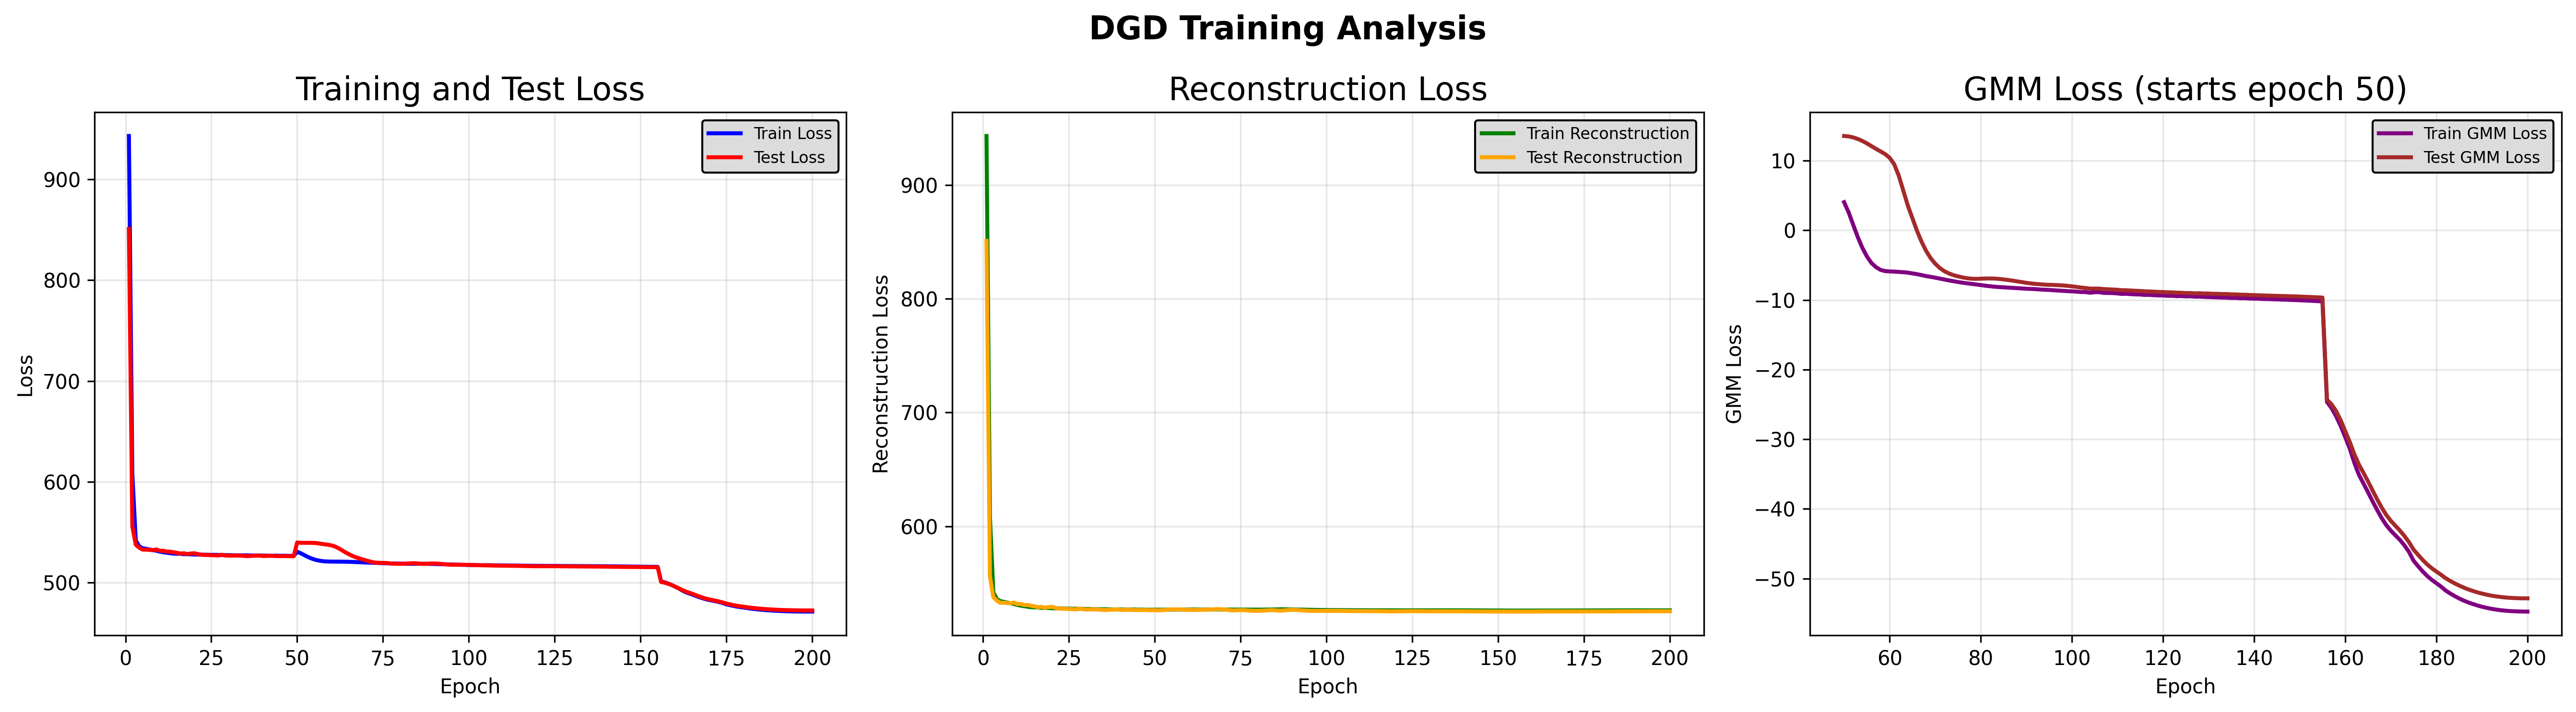

In [ ]:
# Plot comprehensive training analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('DGD Training Analysis', fontsize=16, fontweight='bold')

# 1. Training and Test Loss
axes[0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0].plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Reconstruction Losses
recon_train_losses = trainer.recon_train_losses
recon_test_losses = trainer.recon_test_losses
axes[1].plot(range(1, len(recon_train_losses) + 1), recon_train_losses, 'g-', label='Train Reconstruction', linewidth=2)
axes[1].plot(range(1, len(recon_test_losses) + 1), recon_test_losses, 'orange', label='Test Reconstruction', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. GMM Losses (after GMM starts)
gmm_train_losses = trainer.gmm_train_losses
gmm_test_losses = trainer.gmm_test_losses
gmm_start_epoch = config.training.first_epoch_gmm

if len(gmm_train_losses) > 0 and any(x != 0 for x in gmm_train_losses):
    non_zero_epochs = [i+1 for i, x in enumerate(gmm_train_losses) if x != 0]
    non_zero_train = [x for x in gmm_train_losses if x != 0]
    non_zero_test = [gmm_test_losses[i] for i, x in enumerate(gmm_train_losses) if x != 0]
    
    axes[2].plot(non_zero_epochs, non_zero_train, 'purple', label='Train GMM Loss', linewidth=2)
    axes[2].plot(non_zero_epochs, non_zero_test, 'brown', label='Test GMM Loss', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('GMM Loss')
    axes[2].set_title(f'GMM Loss (starts epoch {gmm_start_epoch})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'GMM not fitted yet\nor no GMM loss', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('GMM Loss')

plt.tight_layout()
plt.show()


🔍 Evaluating trained DGD model...
- Reconstruction MSE - Train: 0.675179 ± 0.153834
- Reconstruction MSE - Test: 0.653624 ± 0.149121


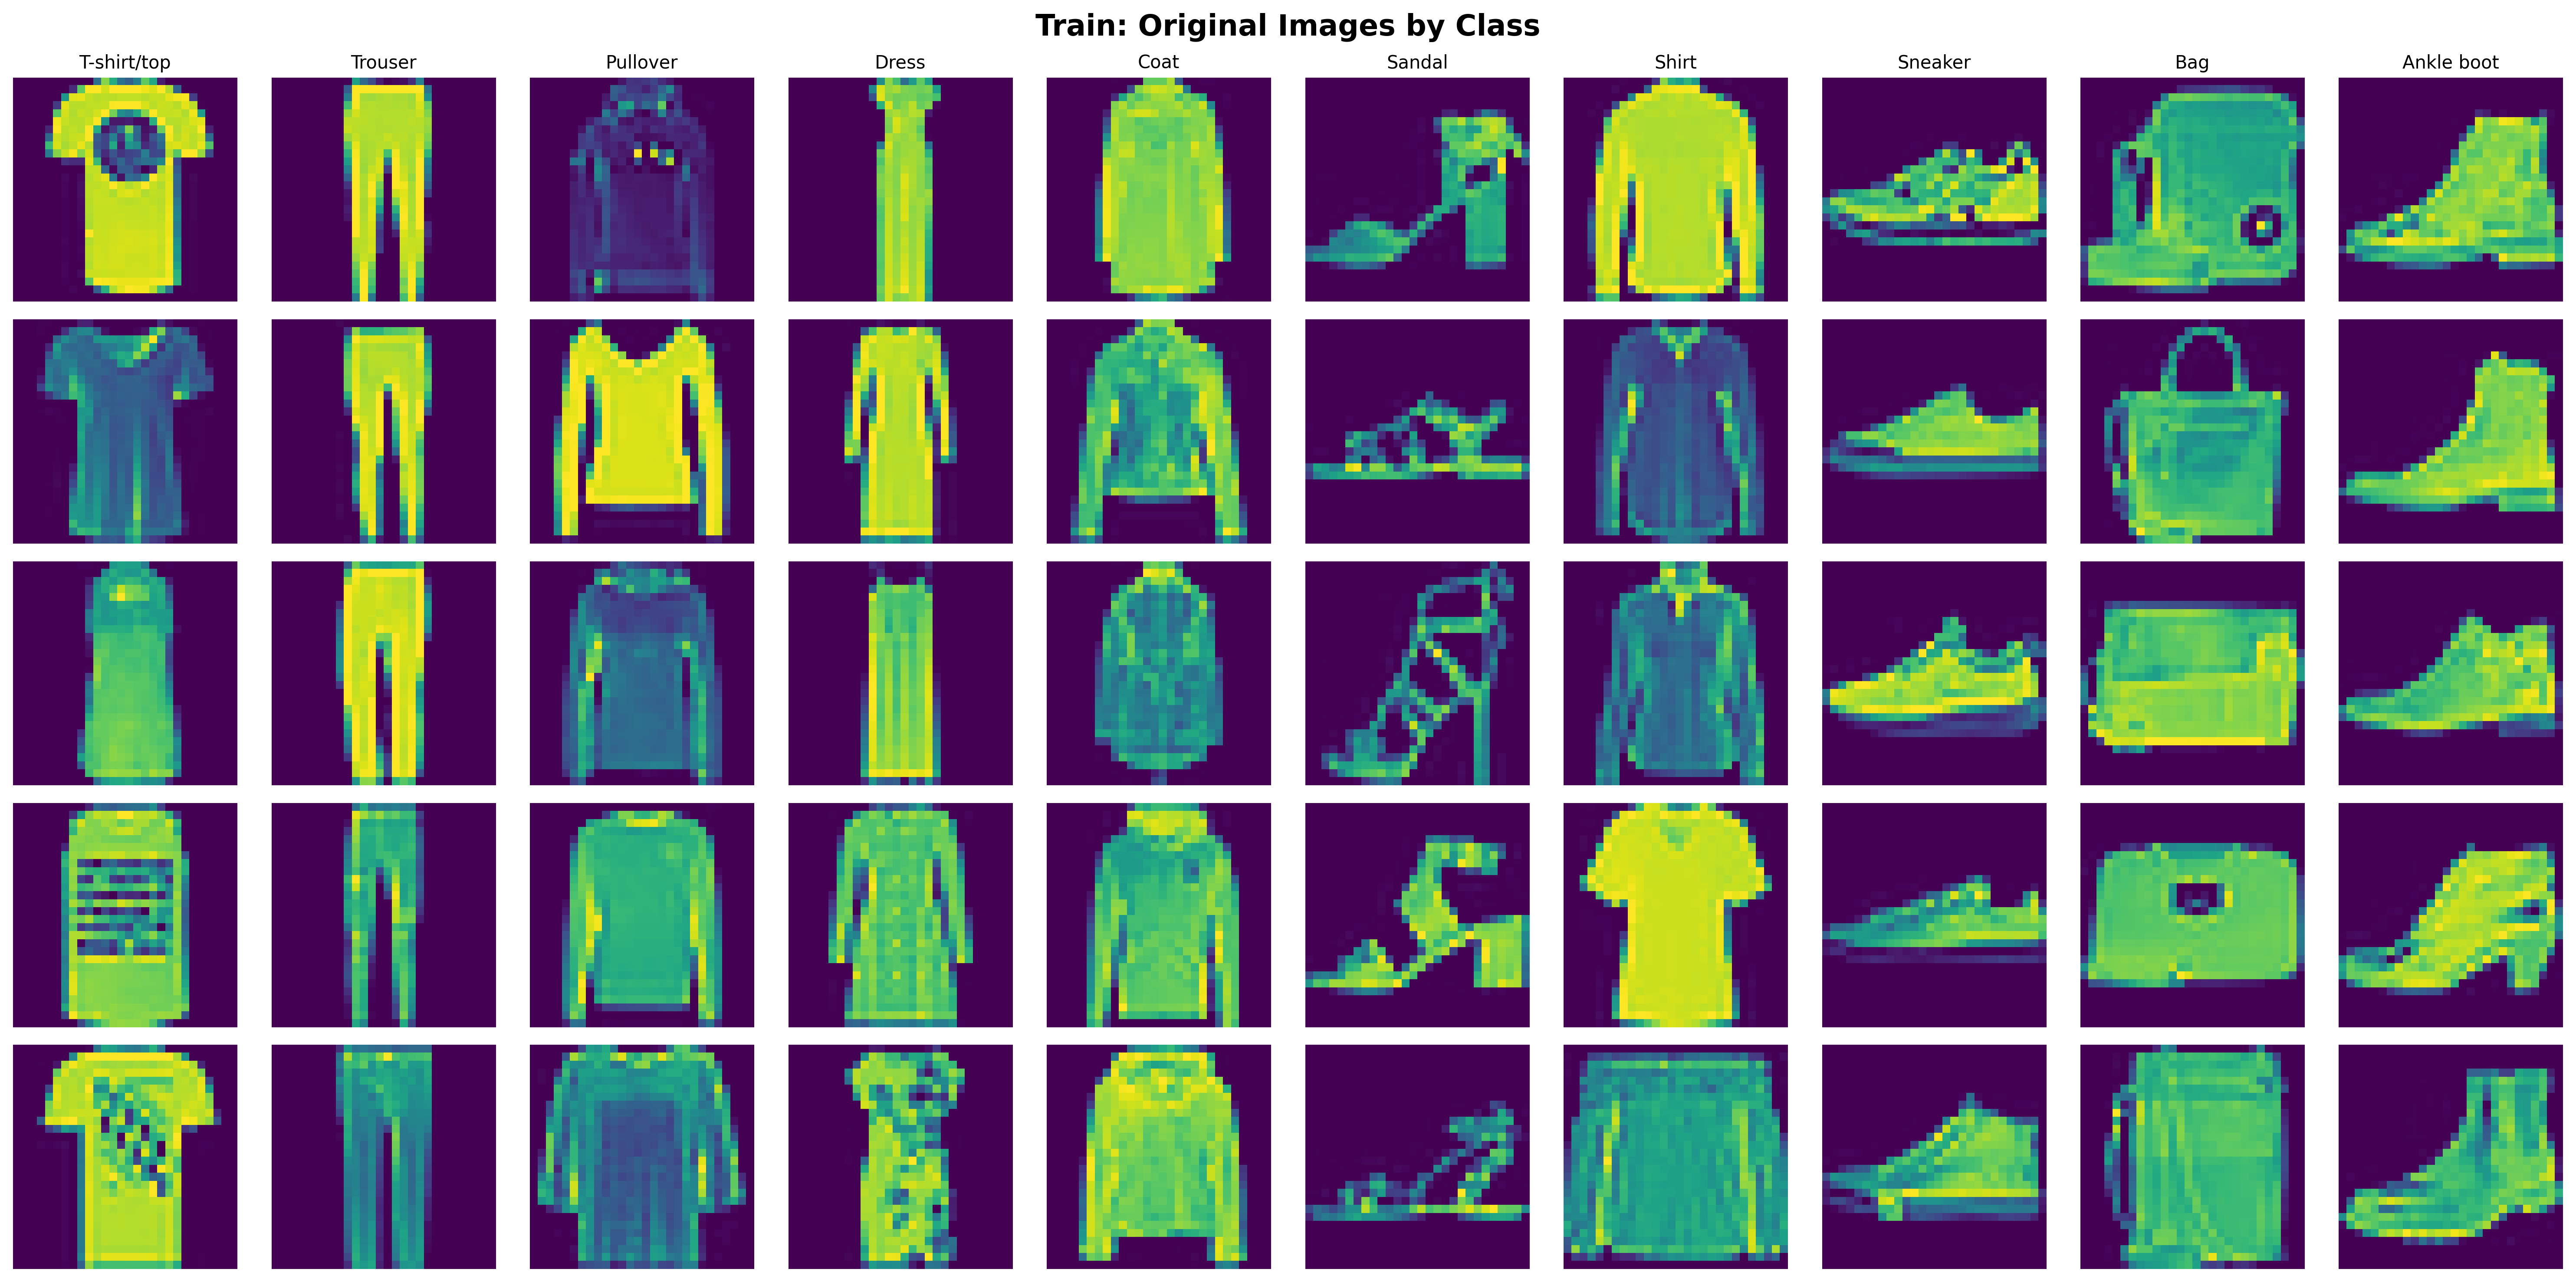

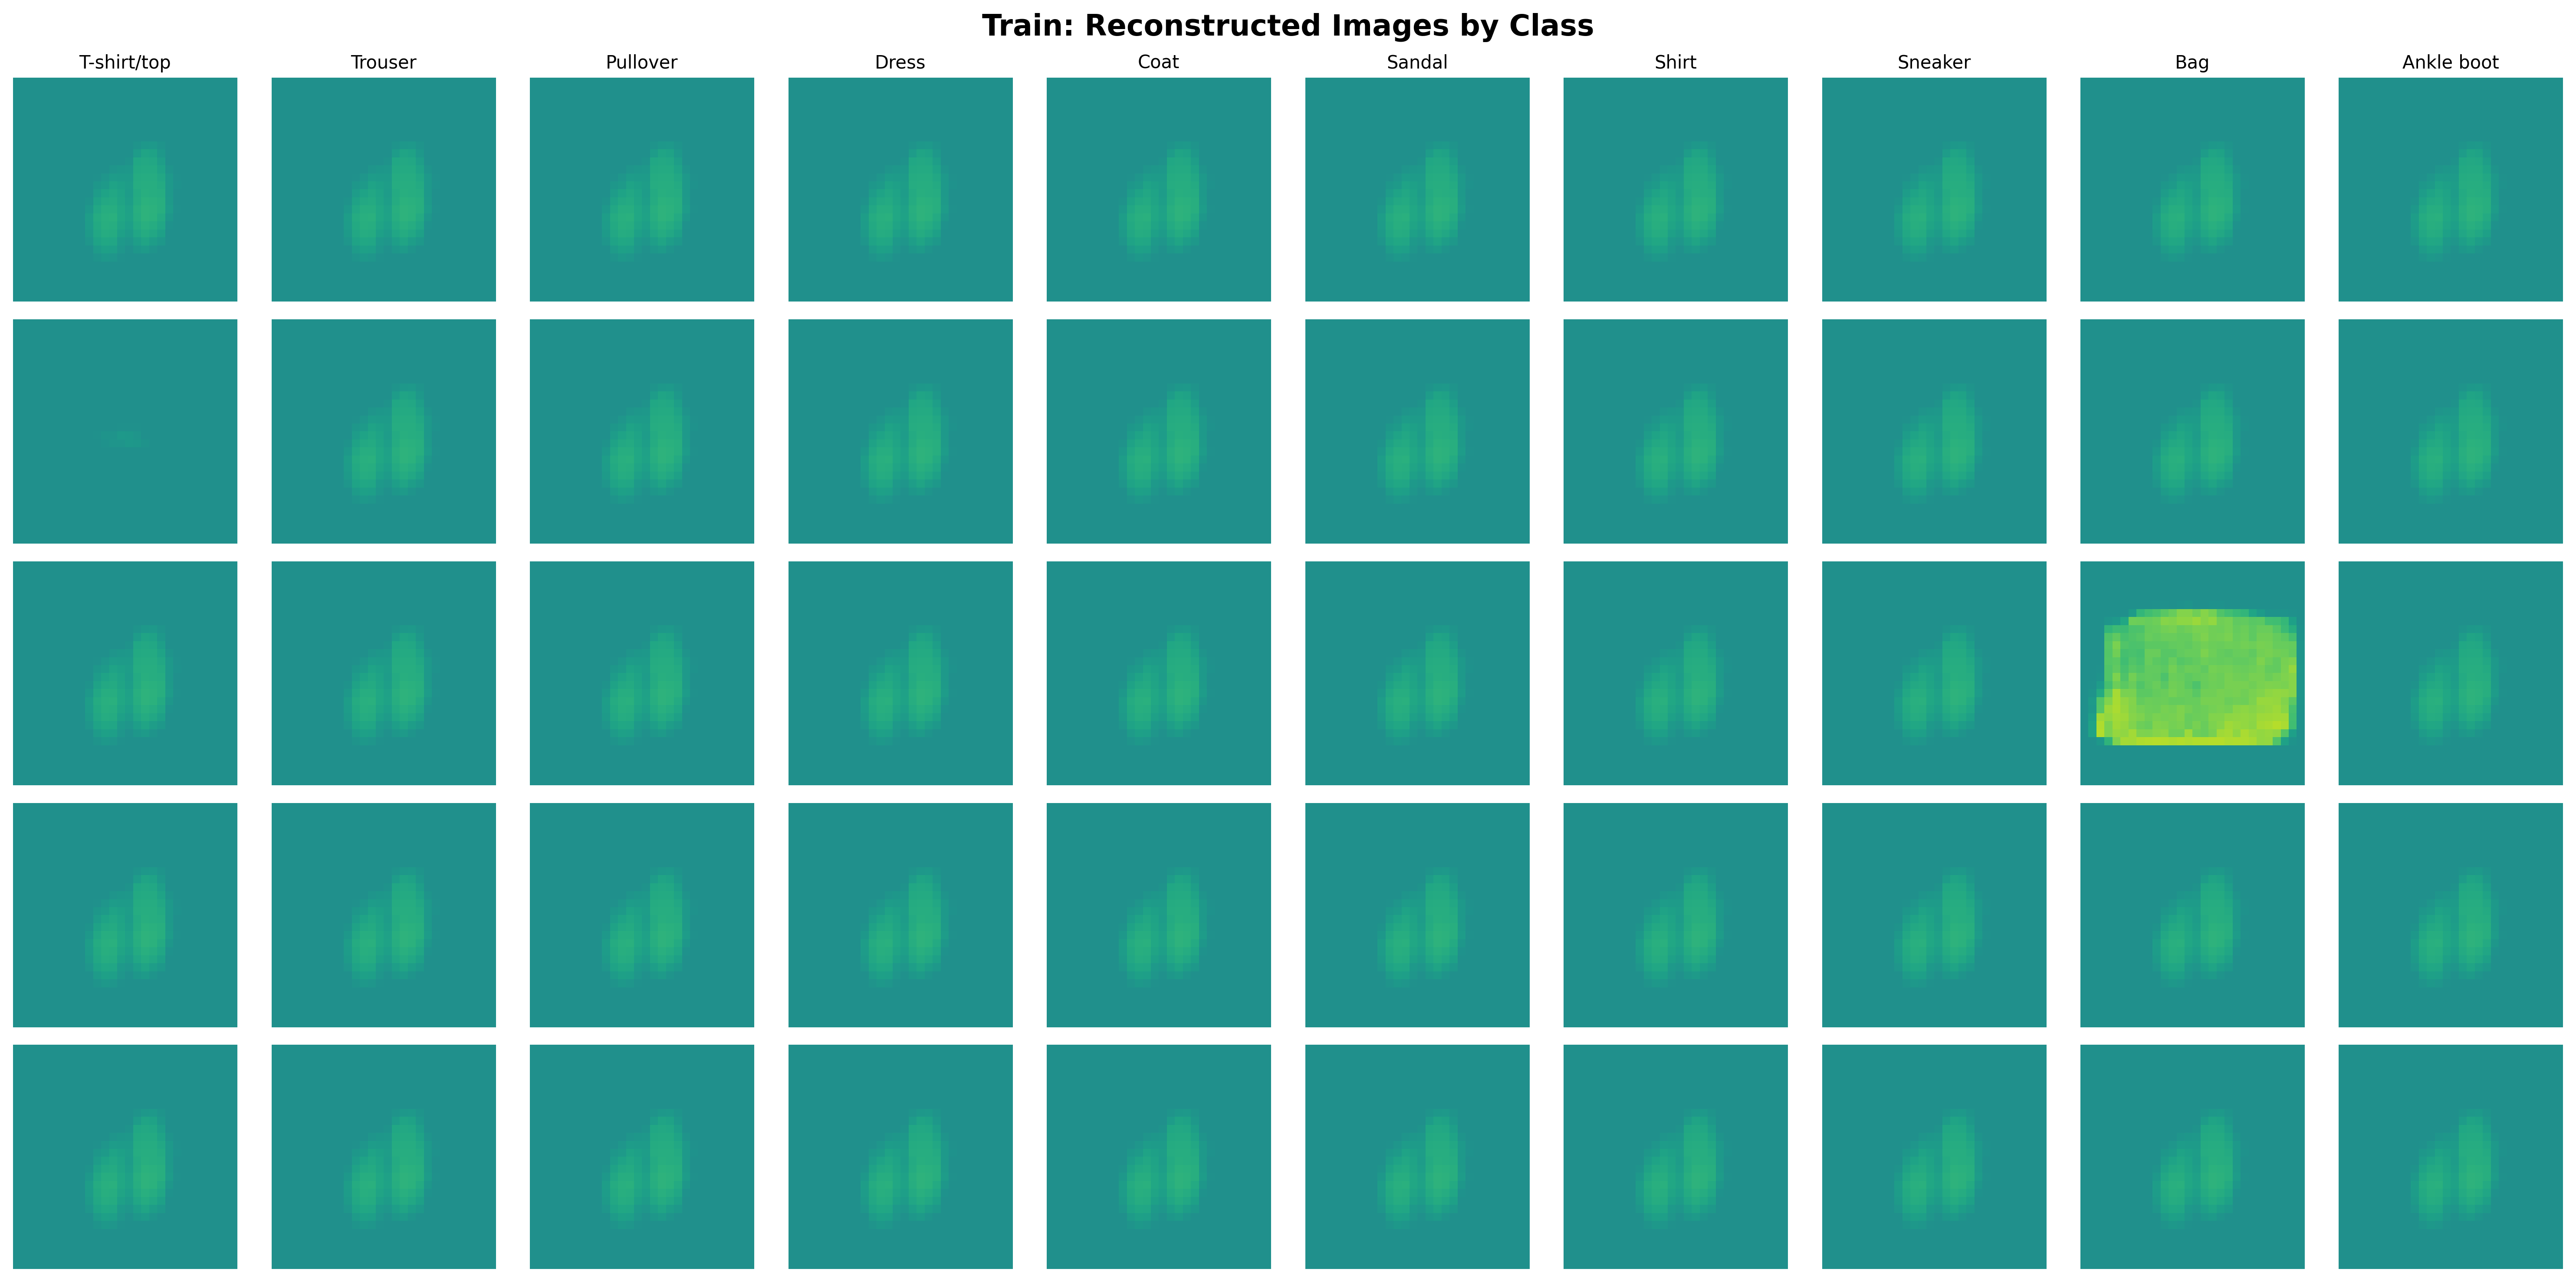

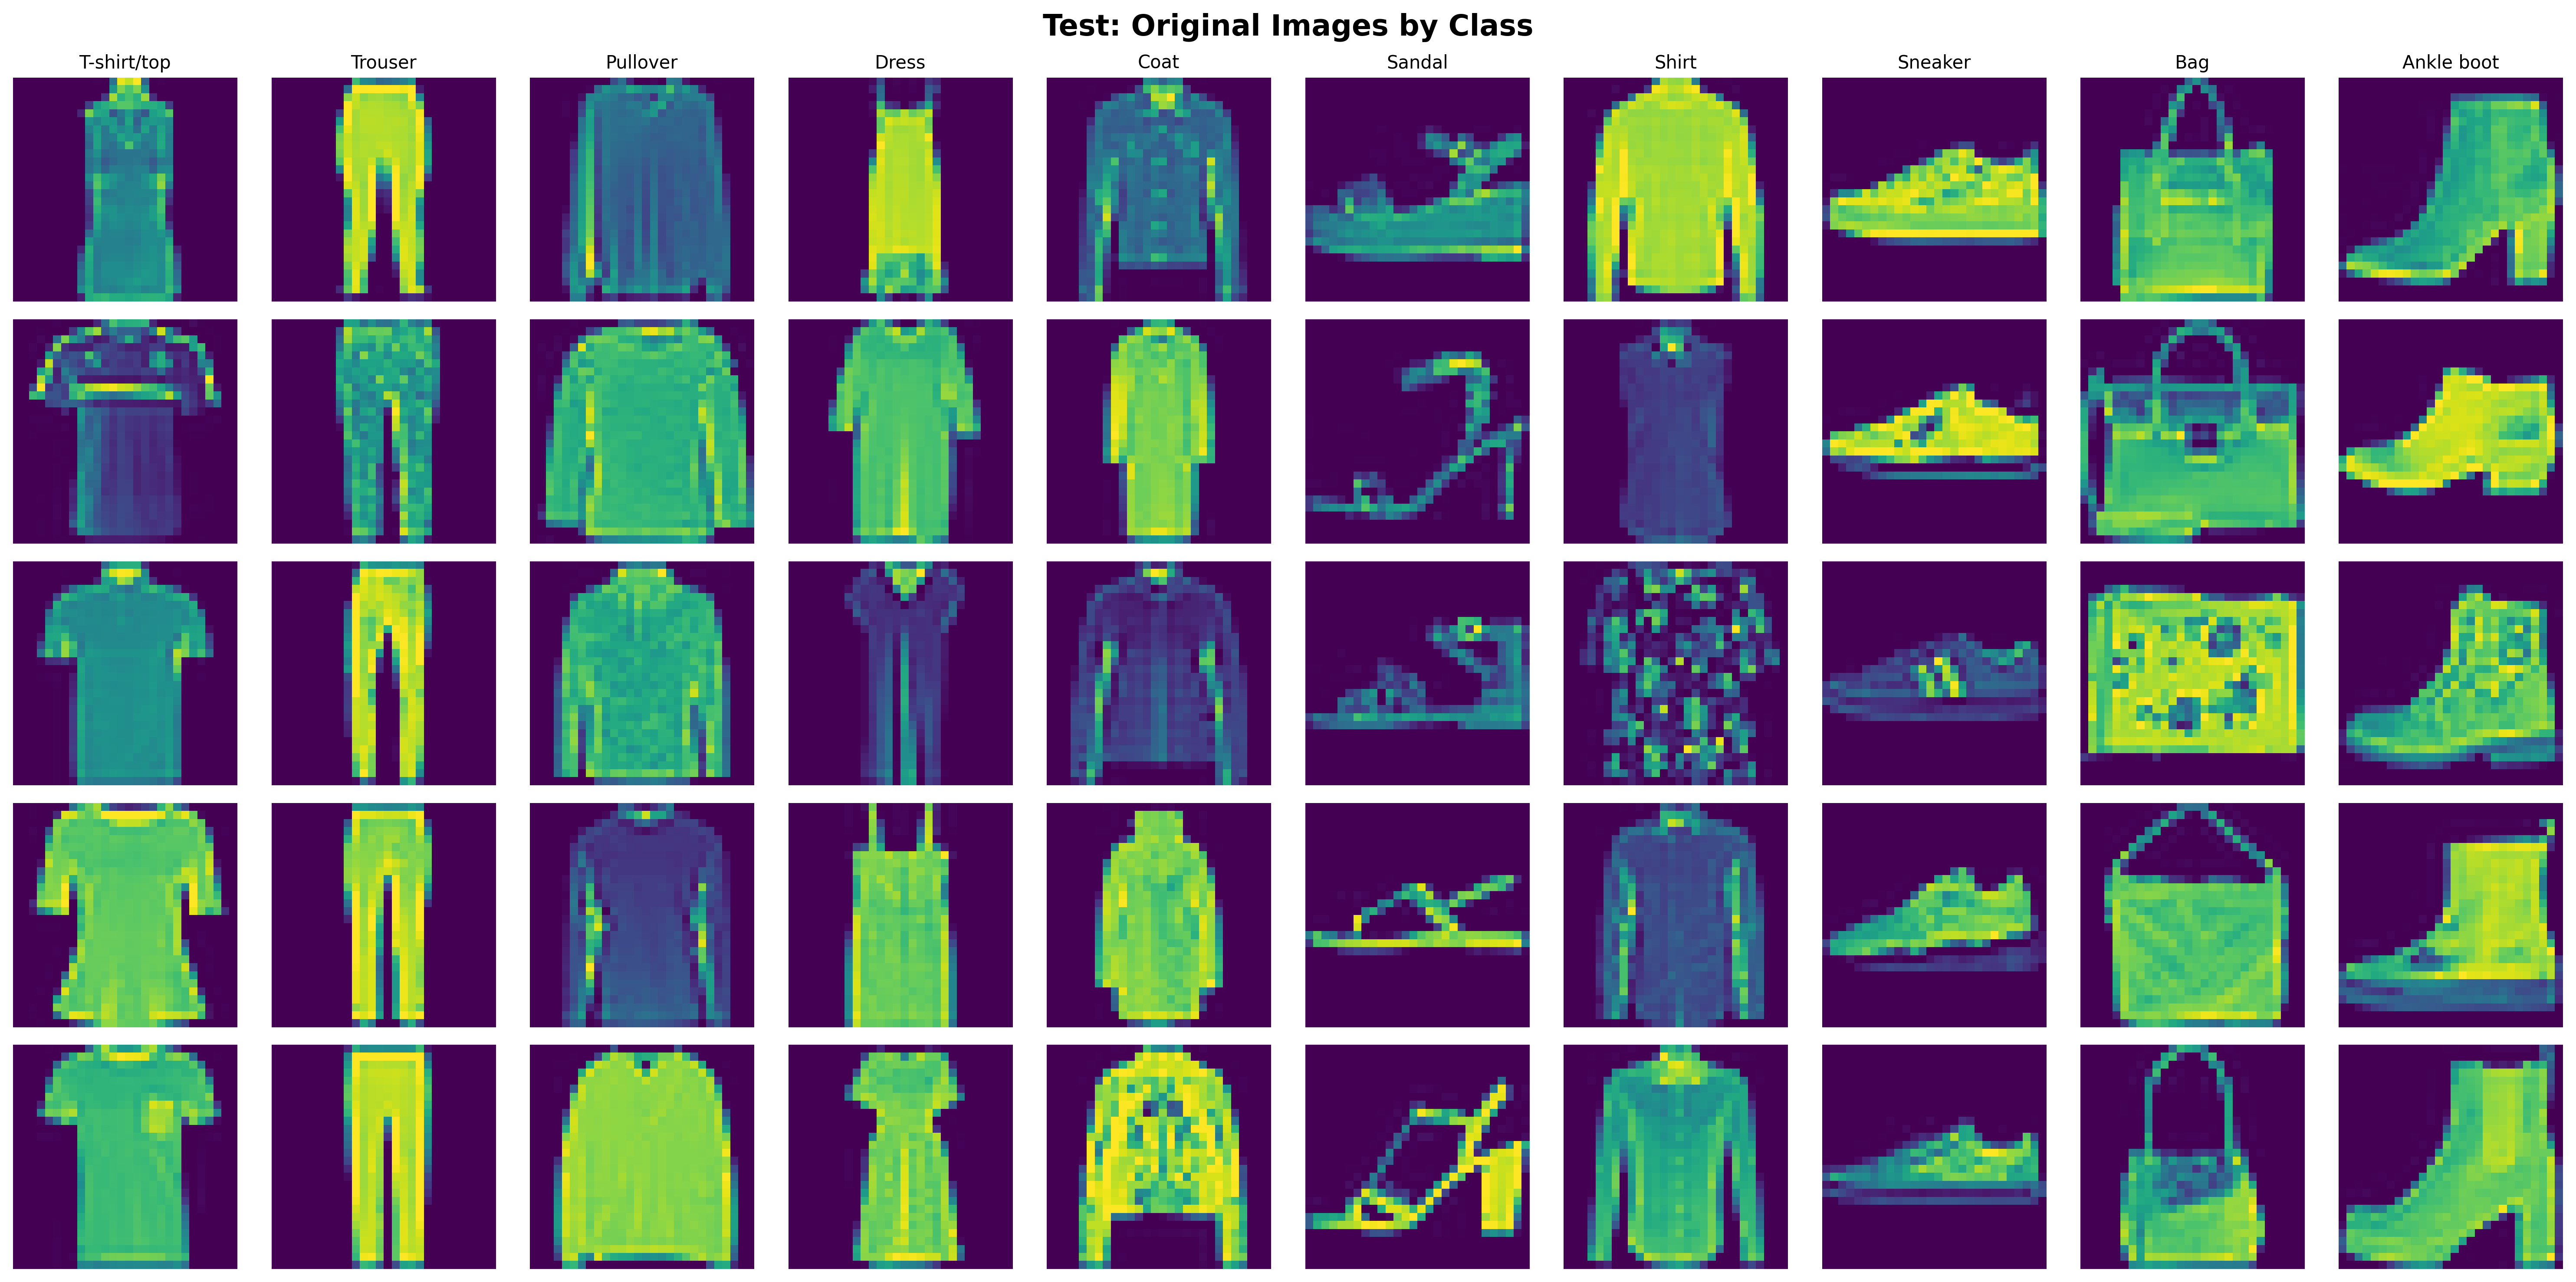

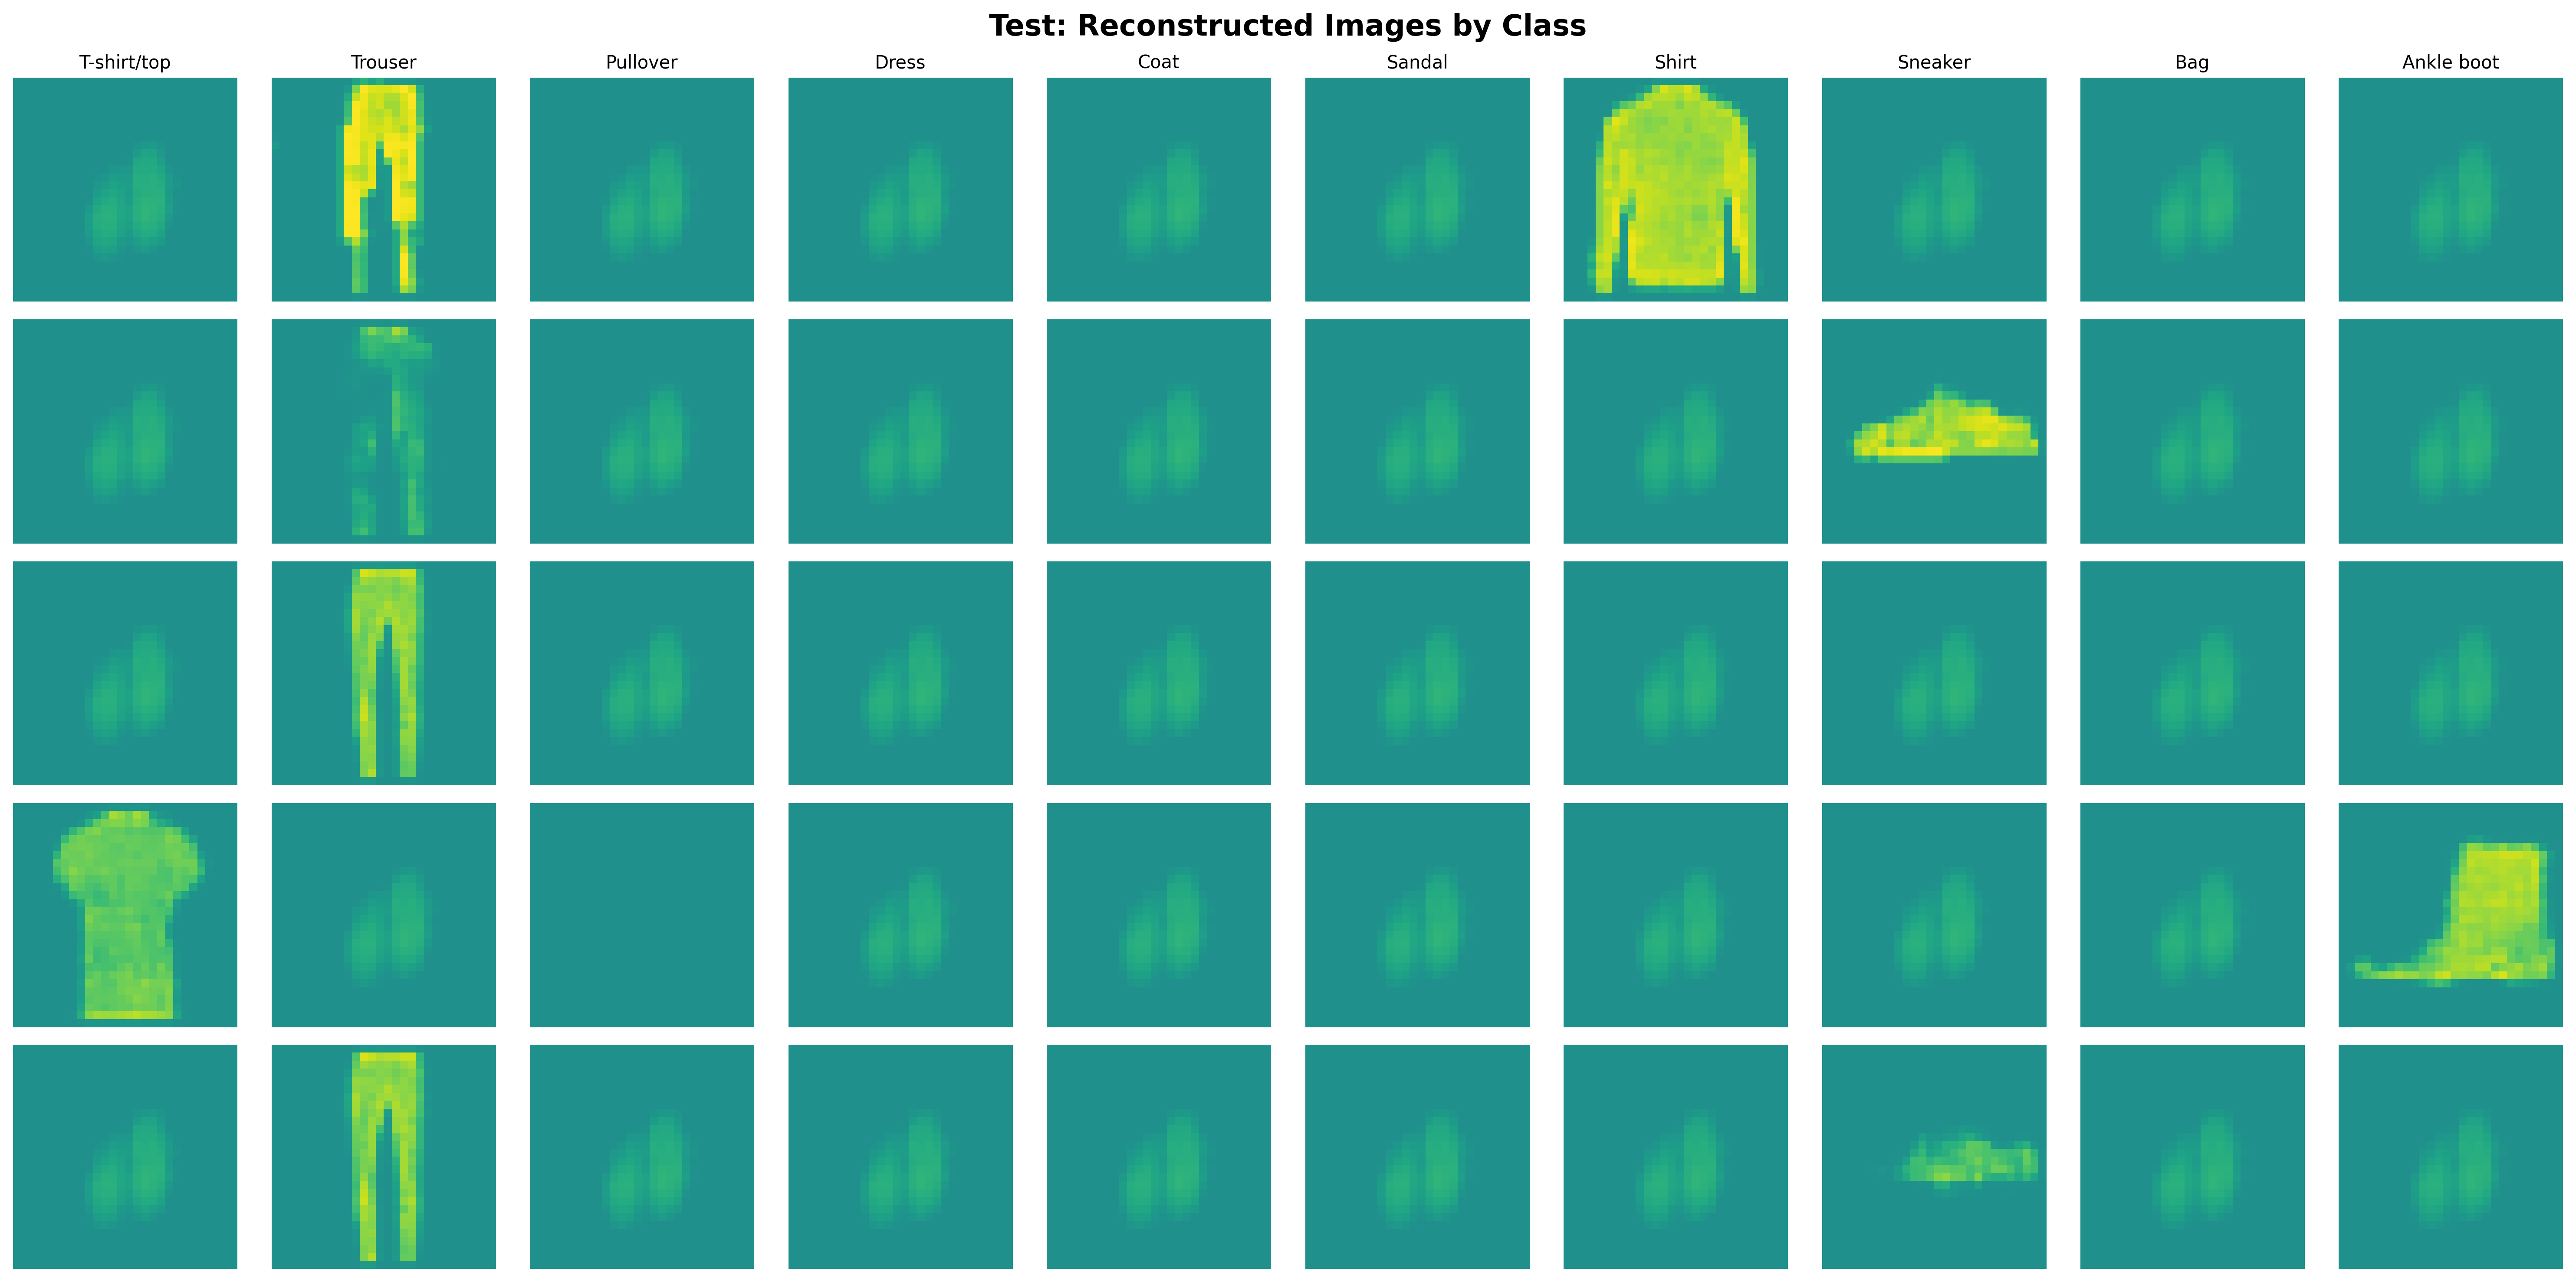

In [ ]:
# Evaluate the trained model
print("🔍 Evaluating trained DGD model...")

# Set model to evaluation mode
model.eval()

# Generate reconstructions
with torch.no_grad():
    # Move to device
    indices_train = sample_data[0].to(device)
    images_train = sample_data[1].to(device)
    labels_train = sample_data[2]
    indices_test = sample_data[3].to(device)
    images_test = sample_data[4].to(device)
    labels_test = sample_data[5]
    
    # Generate reconstructions
    z_train = rep_layer(indices_train)
    recon_train = model.decoder(z_train)
    
    z_test = test_rep_layer(indices_test)
    recon_test = model.decoder(z_test)
    
    # Compute reconstruction errors
    train_mse = F.mse_loss(recon_train, images_train, reduction='none').mean(dim=[1,2,3])
    test_mse = F.mse_loss(recon_test, images_test, reduction='none').mean(dim=[1,2,3])
    
    print(f"- Reconstruction MSE - Train: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
    print(f"- Reconstruction MSE - Test: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# Visualize train originals
plot_images_by_class(
    images=images_train,
    labels=labels_train,
    class_names=class_names,
    title='Train: Original Images by Class',
    n_per_class=5,
    cmap='viridis'
)
plt.show()

# Visualize train reconstructions
plot_images_by_class(
    images=recon_train,
    labels=labels_train,
    class_names=class_names,
    title='Train: Reconstructed Images by Class',
    n_per_class=5,
    cmap='viridis'
)
plt.show()

# Visualize test originals
plot_images_by_class(
    images=images_test,
    labels=labels_test,
    class_names=class_names,
    title='Test: Original Images by Class',
    n_per_class=5,
    cmap='viridis'
)
plt.show()

# Visualize test reconstructions
plot_images_by_class(
    images=recon_test,
    labels=labels_test,
    class_names=class_names,
    title='Test: Reconstructed Images by Class',
    n_per_class=5,
    cmap='viridis'
)
plt.show()


## 9. Generate Samples from Trained Model

Now let's generate new samples using the trained GMM and explore the latent space capabilities.

- Generated 32 samples from GMM
- Sample shape: torch.Size([32, 1, 28, 28])
- Component distribution: [26  0  0  2  1  0  0  0  0  0  0  0  1  0  0  2]


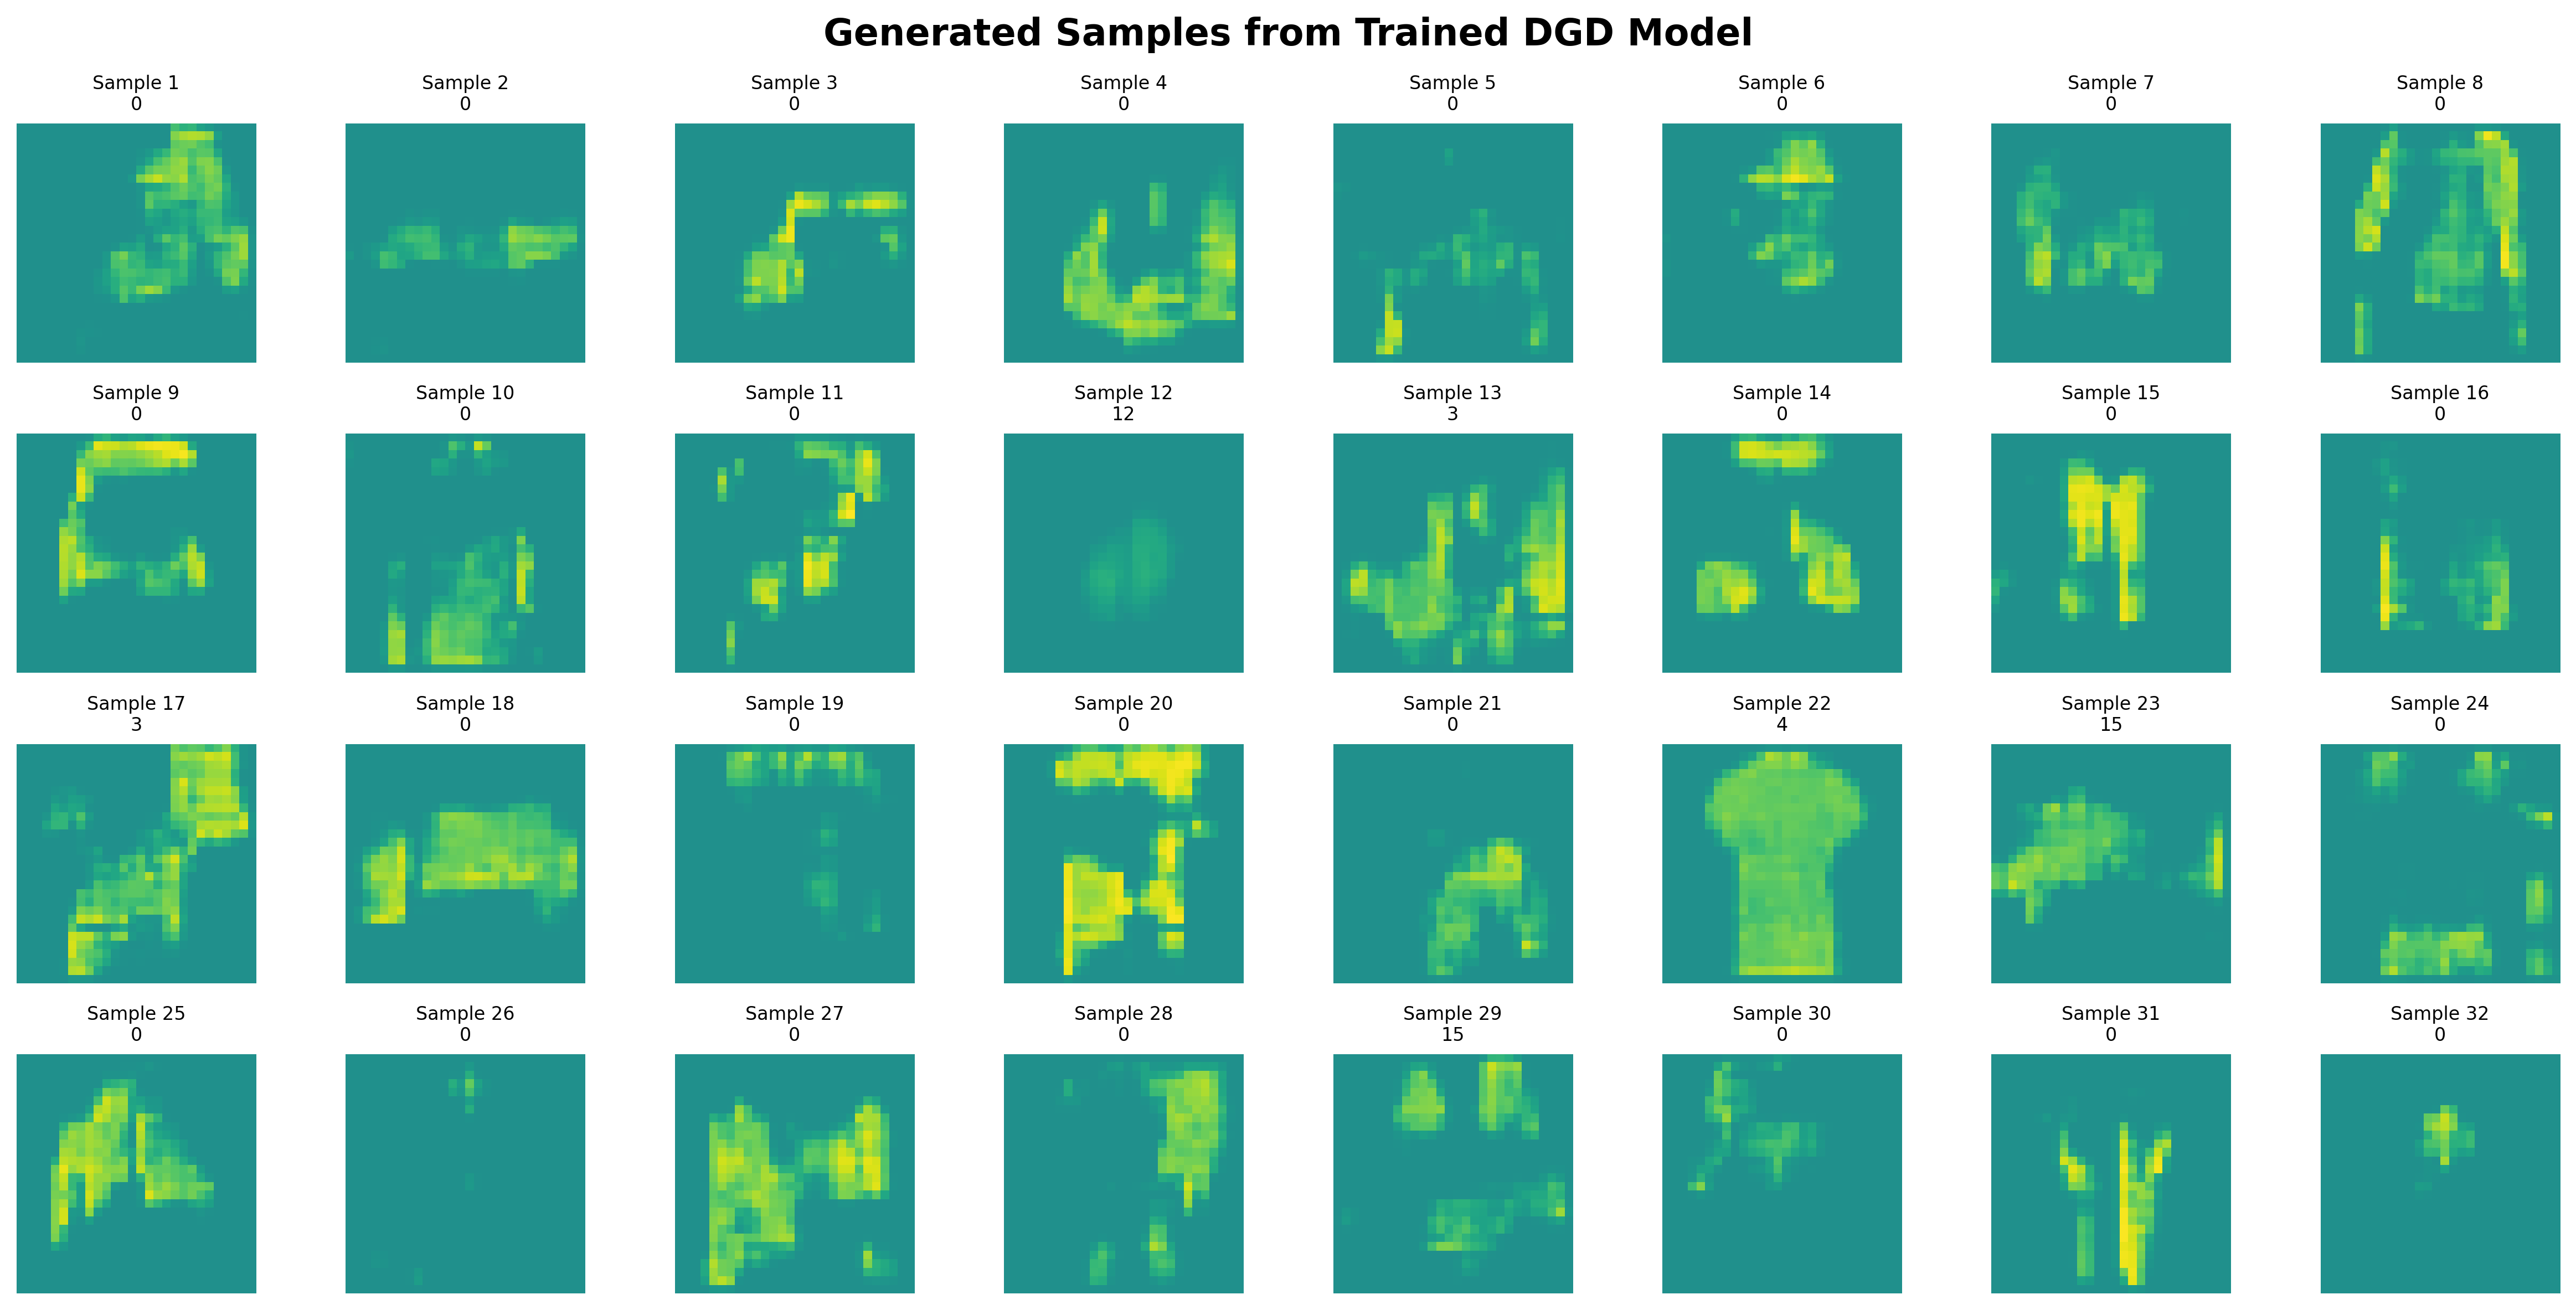

In [ ]:
with torch.no_grad():
    # 1. Sample from GMM
    n_samples = 32
    z_samples, component_labels = gmm.sample(n_samples)
    
    # Generate images from samples
    generated_images = model.decoder(z_samples)
    
    print(f"- Generated {n_samples} samples from GMM")
    print(f"- Sample shape: {generated_images.shape}")
    print(f"- Component distribution: {np.bincount(component_labels.cpu().numpy())}")
    
    # Visualize generated samples using the universal plotting function
    fig = plot_generated_samples(
        generated_images,
        labels=component_labels,
        title='Generated Samples from Trained DGD Model',
        n_cols=8,
        cmap='viridis',
        denormalize=True,
        figsize=(16, 8)
    )
    plt.show()